In [27]:
import copy
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [29]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [30]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr,
    get_hrv
)

In [31]:
class LossFactory:

    def __init__(self, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    # def soft_dtw_loss(self, y_pred, data):

    #     y_true = data.get_label()
    #     num_batches = int(len(y_pred) / self.split_size)
    #     grads = np.zeros_like(y_true)
    #     hesses = np.zeros_like(y_true)

    #     for i in range(num_batches):

    #         y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
    #         y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
    #         grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
    #         grad_curr = grad_curr.flatten()
    #         hess_curr = hess_curr.flatten()

    #         grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
    #         hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

    #     return grads, hesses
    def soft_dtw_loss(self, y_pred, data):

        def batch_loss_helper(i, y_true, y_pred, split_size):
            
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]

            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            return grad_curr, hess_curr

        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        results = Parallel(n_jobs = -1)(
            delayed(batch_loss_helper)(
                i, y_true, y_pred, self.split_size
            ) for i in range(num_batches)
        )

        for i, (grad_curr, hess_curr) in enumerate(results):
            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [35]:
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = None, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = True,
                min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                # hyperparams from LightGBM docs
                max_depth = 7, num_leaves = 75, max_bin = 255,
                num_feats_per_channel = 3, skip_amount = 15):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col

        self.model_type = model_type
        self.random_state = random_state
        self.excluded_subject = excluded_subject

        self.n_estimators = n_estimators
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.early_stopping_rounds = early_stopping_rounds

        self.data_beg = data_beg
        self.data_end = data_end
        self.finetune = finetune

        self.min_bandpass_freq = min_bandpass_freq
        self.max_bandpass_freq = max_bandpass_freq
        self.bandpass_order = bandpass_order
        self.predicted_peaks_prominence = predicted_peaks_prominence
        self.true_peaks_prominence = true_peaks_prominence

        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.max_bin = max_bin

        self.num_feats_per_channel = num_feats_per_channel
        self.skip_amount = skip_amount

        self.gbm = None
        self.training_loss = None
        self.test_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        if self.random_state is not None:
            random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        self.train_data = []
        batch_size = len(self.train_splits) // batches
        print(f'Rows per batch: {batch_size * self.split_size}')
        for batch_num in range(batches):
            batch_split_idxs = random.sample(range(len(self.train_splits)), batch_size)
            batch_splits = [self.train_splits[i] for i in batch_split_idxs]
            self.train_splits = [self.train_splits[i] for i in range(len(self.train_splits)) if i not in batch_split_idxs]

            train_indices = [idx for split in batch_splits for idx in split]
            training_rows = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
            train_X = training_rows.drop(columns = [self.label_col]).to_numpy()
            train_y = training_rows[self.label_col].to_numpy()

            batch_data = lgb.Dataset(train_X, train_y, free_raw_data = False)
            self.train_data.append(batch_data)

        test_indices = [idx for split in self.test_splits for idx in split]
        test_rows = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        test_X = test_rows.drop(columns = [self.label_col]).to_numpy()
        test_y = test_rows[self.label_col].to_numpy()
        self.test_data = lgb.Dataset(test_X, test_y, free_raw_data = False)

        self.loss = LossFactory(self.split_size, loss_type = loss_type, mse_weight = mse_weight, dtw_weight = dtw_weight)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        
        params = {
            'metric': 'None',
            'verbosity': -1,
            'learning_rate': self.learning_rate,
            'objective': 'regression',
            'boosting': self.model_type,
            'max_depth': self.max_depth,
            'num_leaves': self.num_leaves,
            'max_bin': self.max_bin,
        }
    
        if self.model_type == 'rf':
            params['bagging_freq'] = 1
            params['bagging_fraction'] = 0.8


        training_loss_key = 'hr_err'
        feval = self.hr_error_eval_metric
        
        training_meta = {}

        for train_data in self.train_data:
            
            if self.model_type == 'gbdt':
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = self.gbm
                )
            else:
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                )

            mse, hr_err, hr_err_sq = self.eval()
            print(f'Before fine-tuning: MSE = {mse}, HR error = {hr_err}, HR error (squared) = {hr_err_sq}')

            if self.model_type == 'gbdt' and self.finetune:
                
                print('\n\nFine-tuning...')
                gbm_copy = copy.deepcopy(self.gbm)
                pred = gbm_copy.predict(train_data.get_data())
                
                # new_targ = train_data.get_label() - pred
                new_targ = np.ones(len(pred))
                nsplits = len(pred) // self.split_size
                labels = train_data.get_label()
                for i in range(nsplits):
                    pred_curr = pred[i * self.split_size: (i + 1) * self.split_size]
                    label_curr = labels[i * self.split_size: (i + 1) * self.split_size]
                    hr_err = self.get_hr_error(pred_curr, label_curr, square = True)
                    new_targ[i * self.split_size: (i + 1) * self.split_size] = hr_err
                
                new_train_data = lgb.Dataset(train_data.get_data(), label = new_targ)

                self.gbm = lgb.train(
                    params,
                    new_train_data,
                    valid_sets = [new_train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators // 2,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds // 2),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = gbm_copy
                )

            

        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        errs = []
        mses = np.zeros(len(test_X))
        
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))
    
    def validate(self):

        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        
        errors = []
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mse = np.mean(np.square(curr_true - curr_pred))
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            hrv_err = self.get_hrv_error(curr_true, curr_pred, square = False)
            peaks_err = self.get_peaks_error(curr_true, curr_pred, square = False)
            errors.append({
                'mse': mse,
                'hr_err': hr_err,
                'hrv_err': hrv_err,
                'peaks_err': peaks_err
            })

        return errors

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)
        

        print(f'Best test loss: {min(self.test_loss)}\n')
        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err), False
    
    def get_hr_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hr = 60 / np.mean(true_ibis)
        else:
            true_hr = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    def get_peaks_error(self, y_true, y_pred, square = True):
        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)
        if square:
            return np.power(len(true_peaks) - len(pred_peaks), 2)
        return abs(len(true_peaks) - len(pred_peaks))
    
    def get_hrv_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hrv = get_hrv(true_ibis)
        else:
            true_hrv = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hrv = get_hrv(pred_ibis)
        else:
            pred_hrv = 0
        
        if square:
            return np.power(true_hrv - pred_hrv, 2)
        return abs(true_hrv - pred_hrv)
    
    def process_signal(self, y_true, y_pred, smoothing_window = 10, use_bandpass = False):
    
        orig_len = len(y_pred)
        y_pred = n_moving_avg(y_pred, smoothing_window)
        y_pred = resample(y_pred, orig_len)
        if use_bandpass:
            y_pred = bandpass(y_pred, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_pred = min_max_scale(y_pred)
        
        y_true = n_moving_avg(y_true, 20)
        y_true = resample(y_true, orig_len)
        if use_bandpass:
            y_true = bandpass(y_true, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_true = min_max_scale(y_true)
        
        return y_true, y_pred
    
    def get_predicted_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.predicted_peaks_prominence, with_min_dist = True, with_valleys = False)
    def get_true_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.true_peaks_prominence, with_min_dist = True, with_valleys = False)

    def prepare_dataset_from_subjects(self, truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml(self.num_feats_per_channel, self.skip_amount)
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)


In [33]:
def subjectwise_kfold(truths, model_type = 'gbdt', random_state = None, loss_type = 'mse',
                    n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                    mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = True, 
                    min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                    predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                    max_depth = 7, num_leaves = 75, max_bin = 255, num_feats_per_channel = 3, skip_amount = 15,
                    rounds_per_model = 1, collect = False):
        
        models = {}
        for subj_idx in range(len(truths)):
            models[subj_idx + 1] = []
            for i in range(rounds_per_model):
                
                print(f'\n\nTraining excluding subject {subj_idx + 1}...\n')
                mod = LonePineGBM(
                    truths = truths,
                    model_type = model_type,
                    random_state = random_state,
                    loss_type = loss_type,
                    n_estimators = n_estimators,
                    split_size = split_size,
                    learning_rate = learning_rate,
                    test_size = test_size,
                    early_stopping_rounds = early_stopping_rounds,
                    mse_weight = mse_weight,
                    dtw_weight = dtw_weight,
                    data_beg = data_beg,
                    data_end = data_end,
                    batches = batches,
                    finetune = finetune,
                    min_bandpass_freq = min_bandpass_freq,
                    max_bandpass_freq = max_bandpass_freq,
                    bandpass_order = bandpass_order,
                    predicted_peaks_prominence = predicted_peaks_prominence,
                    true_peaks_prominence = true_peaks_prominence,
                    max_depth = max_depth,
                    num_leaves = num_leaves,
                    max_bin = max_bin,
                    num_feats_per_channel = num_feats_per_channel,
                    skip_amount = skip_amount,
                    excluded_subject = subj_idx + 1
                )
                mod.fit()
                models[subj_idx + 1].append(mod)
        
        model_performances = {}
        for subj_idx in models:
            model_performances[subj_idx] = []
            for i in range(rounds_per_model):
                mod = models[subj_idx][i]
                
                if collect:
                    model_performances[subj_idx].append(mod.validate())
                else:
                    model_performances[subj_idx].append(mod.eval())

                
        if collect:
            return model_performances

        mean_hr_score = np.mean([model_performances[subj_idx][i][1] for subj_idx in model_performances for i in range(rounds_per_model)])
        return mean_hr_score, models, model_performances
    

class LonePineOptimizer:

    def __init__(self, truths):
        self.truths = truths
    
    def objective(self, n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                    mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 2000, batches = 1, finetune = True, 
                    min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                    predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                    max_depth = 7, num_leaves = 75, max_bin = 255, num_feats_per_channel = 3, skip_amount = 15):

        hr_score, _, _ = subjectwise_kfold(
            self.truths,
            model_type = 'gbdt',
            random_state = None,
            loss_type = 'combined',
            n_estimators = n_estimators,
            split_size = split_size,
            learning_rate = learning_rate,
            early_stopping_rounds = 50,
            mse_weight = mse_weight,
            dtw_weight = dtw_weight,
            data_beg = data_beg,
            data_end = data_end,
            batches = batches,
            finetune = finetune,
            min_bandpass_freq = min_bandpass_freq,
            max_bandpass_freq = max_bandpass_freq,
            bandpass_order = bandpass_order,
            predicted_peaks_prominence = predicted_peaks_prominence,
            true_peaks_prominence = true_peaks_prominence,
            max_depth = max_depth,
            num_leaves = num_leaves,
            max_bin = max_bin,
            num_feats_per_channel = num_feats_per_channel,
            skip_amount = skip_amount,
        )
        return hr_score
    
    def optimize(self, n_calls = 50):

        space = [
            Integer(50, 300, name = "n_estimators"),
            Integer(640, 1280, name = "split_size"),
            Real(0.002, 0.5, name = "learning_rate"),
            Integer(10, 100, name = "early_stopping_rounds"),
            Real(0.0, 1.0, name = "mse_weight"),
            Real(0.0, 1.0, name = "dtw_weight"),
            Integer(1000, 4000, name = "data_beg"),
            Integer(6000, 10000, name = "data_end"),
            Integer(1, 8, name = "batches"),
            Real(0.4, 1.0, name = "min_bandpass_freq"),
            Real(2.5, 4.0, name = "max_bandpass_freq"),
            Integer(2, 6, name = "bandpass_order"),
            Real(0.1, 0.75, name = "predicted_peaks_prominence"),
            Real(0.1, 0.5, name = "true_peaks_prominence"),
            Integer(3, 10, name = "max_depth"),
            Integer(30, 140, name = "num_leaves"),
            Integer(100, 300, name = "max_bin"),
            Integer(3, 10, name = "num_feats_per_channel"),
            Integer(5, 25, name = "skip_amount"),
        ]

        @use_named_args(space)
        def wrapped_objective(**params):
            return self.objective(**params)
        
        result = gp_minimize(
            wrapped_objective, space, n_calls=n_calls, random_state=42, verbose=1
        )

        return result

In [ ]:
# optimizer = LonePineOptimizer(truths)
# result = optimizer.optimize(n_calls = 50)

In [ ]:
# space = [
#             Integer(50, 300, name = "n_estimators"),
#             Integer(640, 1280, name = "split_size"),
#             Real(0.002, 0.5, name = "learning_rate"),
#             Integer(10, 100, name = "early_stopping_rounds"),
#             Real(0.0, 1.0, name = "mse_weight"),
#             Real(0.0, 1.0, name = "dtw_weight"),
#             Integer(1000, 4000, name = "data_beg"),
#             Integer(6000, 10000, name = "data_end"),
#             Integer(1, 8, name = "batches"),
#             Real(0.4, 1.0, name = "min_bandpass_freq"),
#             Real(2.5, 4.0, name = "max_bandpass_freq"),
#             Integer(2, 6, name = "bandpass_order"),
#             Real(0.1, 0.75, name = "predicted_peaks_prominence"),
#             Real(0.1, 0.5, name = "true_peaks_prominence"),
#             Integer(3, 10, name = "max_depth"),
#             Integer(30, 140, name = "num_leaves"),
#             Integer(100, 300, name = "max_bin"),
#             Integer(3, 10, name = "num_feats_per_channel"),
#             Integer(5, 25, name = "skip_amount"),
#         ]

optimization_res = [188,
 993,
 0.22844583483861589,
 16,
 0.913467044583398,
 1.0,
 3909,
 7474,
 5,
 0.9421772128909808,
 3.6351090994830813,
 4,
 0.17087564911262462,
 0.322741927274642,
 6,
 34,
 235,
 8,
 12]

# result.x

In [ ]:
# np.mean([model_performances[sub][i][1] for sub in model_performances for i in range(3)])

In [85]:
options = [
    {
        'minmax': False,
        'use_wavelet': True,
        'use_bandpass': False
    }
]
rpm = 10

scores = []

for option in options:
    
    truths = []
    for subject in range(1, 8):

        truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
        truth.align_rgb_bvp()
        truth.fill_nans()
        truth.process_rgb(
            minmax = option['minmax'],
            use_wavelet = option['use_wavelet'],
            use_bandpass = option['use_bandpass']
        )
        truth.process_bvp()
        truths.append(truth)


    res = subjectwise_kfold(
        truths, model_type = 'gbdt', random_state = None, loss_type = 'combined', rounds_per_model = rpm,
        n_estimators = 188, split_size = 960, learning_rate = 0.01,
        early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 2500, data_end = 10180,
        batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
        predicted_peaks_prominence = 0.17, true_peaks_prominence = 0.22, max_depth = 6,
        num_leaves = 34, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
    )

    scores.append(res)



Training excluding subject 1...

Rows per batch: 4800


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 16.8395	test's hr_err: 27.0683
[10]	train's hr_err: 13.2804	test's hr_err: 29.1819
[15]	train's hr_err: 15.2318	test's hr_err: 24.61
Early stopping, best iteration is:
[1]	train's hr_err: 16.3357	test's hr_err: 23.0759
Before fine-tuning: MSE = 0.08333980952292035, HR error = 23.65511854543017, HR error (squared) = 770.4065338758875


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 36.9893	test's hr_err: 27.452
[10]	train's hr_err: 36.9893	test's hr_err: 27.452
Early stopping, best iteration is:
[2]	train's hr_err: 36.9893	test's hr_err: 27.452
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 24.014	test's hr_err: 26.6282
[10]	train's hr_err: 23.9864	test's hr_err: 26.0552
[15]	train's hr_err: 23.9864	test's hr_err: 26.1574
[20]	train's hr_err: 24.8737	test's hr_err: 25.7067
[25]	train's hr_err: 23.0603	test's hr_err: 25.8851
[3

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 19.4398	test's hr_err: 23.5705
[10]	train's hr_err: 17.3952	test's hr_err: 27.3071
[15]	train's hr_err: 17.4855	test's hr_err: 27.2412
Early stopping, best iteration is:
[3]	train's hr_err: 17.0051	test's hr_err: 21.4483
Before fine-tuning: MSE = 0.09693374141277128, HR error = 23.645563235539438, HR error (squared) = 871.3498978359928


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 59.7292	test's hr_err: 26.293
[10]	train's hr_err: 59.7292	test's hr_err: 26.293
Early stopping, best iteration is:
[4]	train's hr_err: 59.7292	test's hr_err: 26.293
[5]	train's hr_err: 17.0325	test's hr_err: 26.293
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 17.0325	test's hr_err: 26.3121
[15]	train's hr_err: 17.0325	test's hr_err: 26.6349
[20]	train's hr_err: 17.0325	test's hr_err: 26.6349
Early stopping, best iteration is:
[6]	train's hr_e

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.5224	test's hr_err: 26.7494
[10]	train's hr_err: 14.9317	test's hr_err: 26.4893
[15]	train's hr_err: 13.2495	test's hr_err: 26.9923
[20]	train's hr_err: 13.4712	test's hr_err: 29.3477
[25]	train's hr_err: 7.80972	test's hr_err: 27.6376
[30]	train's hr_err: 6.74157	test's hr_err: 29.5799
Early stopping, best iteration is:
[16]	train's hr_err: 13.2495	test's hr_err: 26.1247
Before fine-tuning: MSE = 0.0806272494733602, HR error = 27.67483526321229, HR error (squared) = 1069.958367207134


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 56.9112	test's hr_err: 14.5434
[25]	train's hr_err: 56.9112	test's hr_err: 14.5434
Early stopping, best iteration is:
[19]	train's hr_err: 56.9112	test's hr_err: 14.5434
[20]	train's hr_err: 17.4068	test's hr_err: 15.2769
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 22.4859	test's hr_err: 1

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.27071	test's hr_err: 15.3717
[10]	train's hr_err: 7.94121	test's hr_err: 13.5154
[15]	train's hr_err: 8.14086	test's hr_err: 13.2163
[20]	train's hr_err: 6.4035	test's hr_err: 16.555
[25]	train's hr_err: 4.70588	test's hr_err: 17.5834
[30]	train's hr_err: 4.81895	test's hr_err: 15.3163
Early stopping, best iteration is:
[14]	train's hr_err: 8.14086	test's hr_err: 12.4629
Before fine-tuning: MSE = 0.07577467624452142, HR error = 14.344861003860055, HR error (squared) = 334.89181880508477


Fine-tuning...
[15]	train's hr_err: 61.1126	test's hr_err: 23.2579
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 61.9708	test's hr_err: 23.2579
Early stopping, best iteration is:
[15]	train's hr_err: 61.1126	test's hr_err: 23.2579
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 13.3051	test's hr_err: 23.5624
[25]	train's hr_err: 21.5594	test's hr_err: 

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 7.95125	test's hr_err: 22.1481
[10]	train's hr_err: 8.85569	test's hr_err: 23.6274
[15]	train's hr_err: 9.97629	test's hr_err: 22.0281
[20]	train's hr_err: 9.43079	test's hr_err: 20.0268
[25]	train's hr_err: 5.60734	test's hr_err: 20.2433
[30]	train's hr_err: 6.07099	test's hr_err: 22.1617
[35]	train's hr_err: 6.05371	test's hr_err: 23.6457
Early stopping, best iteration is:
[22]	train's hr_err: 8.2541	test's hr_err: 19.9799
Before fine-tuning: MSE = 0.08588333116443392, HR error = 19.992429855672867, HR error (squared) = 662.5776204811415


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[25]	train's hr_err: 65.945	test's hr_err: 27.6176
[30]	train's hr_err: 65.945	test's hr_err: 27.6209
Early stopping, best iteration is:
[23]	train's hr_err: 65.945	test's hr_err: 27.6176
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 14.4912	test's hr_err: 24.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.1158	test's hr_err: 18.5949
[10]	train's hr_err: 17.5706	test's hr_err: 17.457
[15]	train's hr_err: 14.9891	test's hr_err: 16.4879
[20]	train's hr_err: 17.6043	test's hr_err: 15.3382
[25]	train's hr_err: 17.6338	test's hr_err: 15.2789
[30]	train's hr_err: 18.5707	test's hr_err: 15.1909
Early stopping, best iteration is:
[17]	train's hr_err: 14.152	test's hr_err: 14.4218
Before fine-tuning: MSE = 0.09059765226301983, HR error = 18.358495318489894, HR error (squared) = 409.3154179565547


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 59.5793	test's hr_err: 25.2845
[25]	train's hr_err: 59.5793	test's hr_err: 25.2845
Early stopping, best iteration is:
[18]	train's hr_err: 59.5793	test's hr_err: 25.2845
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 34.7958	test's hr_err: 22.4585
[25]	train's hr_err: 28.2494	test's hr_err: 1

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.5235	test's hr_err: 22.4908
[10]	train's hr_err: 17.5879	test's hr_err: 23.4804
[15]	train's hr_err: 16.8772	test's hr_err: 25.7176
Early stopping, best iteration is:
[1]	train's hr_err: 20.2212	test's hr_err: 21.4713
Before fine-tuning: MSE = 0.10603217276449212, HR error = 23.963093834730135, HR error (squared) = 764.9237989834791


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 52.1986	test's hr_err: 21.8384
[10]	train's hr_err: 52.1986	test's hr_err: 21.8384
Early stopping, best iteration is:
[2]	train's hr_err: 52.1986	test's hr_err: 21.8384
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 15.0798	test's hr_err: 20.9061
[10]	train's hr_err: 15.0798	test's hr_err: 20.6635
[15]	train's hr_err: 15.0798	test's hr_err: 20.7114
[20]	train's hr_err: 15.0798	test's hr_err: 21.1214
[25]	train's hr_err: 14.134	test's hr_err: 20.7

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 6.36436	test's hr_err: 16.071
[10]	train's hr_err: 11.2929	test's hr_err: 19.4011
[15]	train's hr_err: 11.171	test's hr_err: 16.8392
[20]	train's hr_err: 9.73392	test's hr_err: 15.7677
Early stopping, best iteration is:
[4]	train's hr_err: 6.08814	test's hr_err: 14.7646
Before fine-tuning: MSE = 0.09221748873083326, HR error = 16.85160849571095, HR error (squared) = 341.9466364711829


Fine-tuning...
[5]	train's hr_err: 64.4762	test's hr_err: 22.4376
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 64.4638	test's hr_err: 22.4306
[15]	train's hr_err: 64.4638	test's hr_err: 22.4306
Early stopping, best iteration is:
[8]	train's hr_err: 64.4638	test's hr_err: 22.4306
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 8.86502	test's hr_err: 21.829
[15]	train's hr_err: 8.86502	test's hr_err: 22.2332
[20]	train's hr_err: 11.4896	test's hr_err: 21.620

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.0786	test's hr_err: 22.2792
[10]	train's hr_err: 12.8692	test's hr_err: 21.3856
[15]	train's hr_err: 10.8627	test's hr_err: 22.2025
[20]	train's hr_err: 12.1574	test's hr_err: 22.0336
Early stopping, best iteration is:
[8]	train's hr_err: 12.8692	test's hr_err: 20.9334
Before fine-tuning: MSE = 0.10257051293179824, HR error = 22.347516979489264, HR error (squared) = 615.1171451942133


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 58.5443	test's hr_err: 28.4853
[15]	train's hr_err: 58.5443	test's hr_err: 28.4853
Early stopping, best iteration is:
[9]	train's hr_err: 58.5443	test's hr_err: 28.4853
[10]	train's hr_err: 10.9804	test's hr_err: 28.1545
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 11.8309	test's hr_err: 27.8726
[20]	train's hr_err: 10.7613	test's hr_err: 28.2021
[25]	train's hr_err: 10.7613	test's hr_err: 2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.2251	test's hr_err: 21.5767
[10]	train's hr_err: 10.0743	test's hr_err: 24.5306
[15]	train's hr_err: 13.4979	test's hr_err: 26.5364
Early stopping, best iteration is:
[2]	train's hr_err: 17.5476	test's hr_err: 14.7442
Before fine-tuning: MSE = 0.08844271179473057, HR error = 17.984077313890456, HR error (squared) = 390.43082229637605


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 51.0289	test's hr_err: 27.5133
[10]	train's hr_err: 51.0289	test's hr_err: 27.5133
Early stopping, best iteration is:
[4]	train's hr_err: 51.0289	test's hr_err: 27.5133
[5]	train's hr_err: 47.572	test's hr_err: 27.5165
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 47.572	test's hr_err: 27.5094
[15]	train's hr_err: 47.5587	test's hr_err: 26.4685
[20]	train's hr_err: 46.732	test's hr_err: 26.8119
[25]	train's hr_err: 46.732	test's hr_err: 27.133

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.0567	test's hr_err: 35.0515
[10]	train's hr_err: 15.2619	test's hr_err: 29.4038
[15]	train's hr_err: 22.4993	test's hr_err: 20.6182
[20]	train's hr_err: 20.9287	test's hr_err: 22.0162
[25]	train's hr_err: 14.2028	test's hr_err: 23.62
[30]	train's hr_err: 14.1696	test's hr_err: 22.0458
Early stopping, best iteration is:
[18]	train's hr_err: 22.5237	test's hr_err: 18.8826
Before fine-tuning: MSE = 0.09668975212169172, HR error = 17.73250771585455, HR error (squared) = 539.7159312988435


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 42.8293	test's hr_err: 30.8709
[25]	train's hr_err: 42.8293	test's hr_err: 30.8709
Early stopping, best iteration is:
[19]	train's hr_err: 42.8293	test's hr_err: 30.8709
[20]	train's hr_err: 22.7627	test's hr_err: 31.8674
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 22.0223	test's hr_err: 37

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 28.6208	test's hr_err: 38.5713
[10]	train's hr_err: 27.3276	test's hr_err: 47.9676
[15]	train's hr_err: 28.2329	test's hr_err: 38.9553
[20]	train's hr_err: 14.6449	test's hr_err: 37.9085
Early stopping, best iteration is:
[6]	train's hr_err: 30.1347	test's hr_err: 30.9083
Before fine-tuning: MSE = 0.08849342445066001, HR error = 39.89330398324843, HR error (squared) = 2302.261196437344


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 47.5997	test's hr_err: 32.0319
[15]	train's hr_err: 47.5997	test's hr_err: 32.0319
Early stopping, best iteration is:
[7]	train's hr_err: 47.5997	test's hr_err: 32.0319
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 19.6456	test's hr_err: 32.4288
[15]	train's hr_err: 19.6456	test's hr_err: 32.7793
[20]	train's hr_err: 19.6456	test's hr_err: 31.5782
[25]	train's hr_err: 19.6456	test's hr_err: 30

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 16.4936	test's hr_err: 26.0586
[10]	train's hr_err: 18.216	test's hr_err: 25.9383
[15]	train's hr_err: 17.1542	test's hr_err: 24.9153
[20]	train's hr_err: 16.8838	test's hr_err: 25.7355
Early stopping, best iteration is:
[8]	train's hr_err: 17.073	test's hr_err: 22.9222
Before fine-tuning: MSE = 0.08953251111136215, HR error = 20.978580895131298, HR error (squared) = 828.285315420922


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 65.1215	test's hr_err: 29.256
[15]	train's hr_err: 65.1215	test's hr_err: 29.256
Early stopping, best iteration is:
[9]	train's hr_err: 65.1215	test's hr_err: 29.256
[10]	train's hr_err: 36.4643	test's hr_err: 29.3513
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 31.4758	test's hr_err: 25.0289
[20]	train's hr_err: 33.7234	test's hr_err: 26.0807
[25]	train's hr_err: 33.4003	test's hr_err: 26.9245

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 10.7132	test's hr_err: 23.9782
[10]	train's hr_err: 12.5484	test's hr_err: 20.7068
[15]	train's hr_err: 7.77514	test's hr_err: 32.4307
[20]	train's hr_err: 11.441	test's hr_err: 34.9184
[25]	train's hr_err: 12.2474	test's hr_err: 38.0395
Early stopping, best iteration is:
[10]	train's hr_err: 12.5484	test's hr_err: 20.7068
Before fine-tuning: MSE = 0.09827792421177316, HR error = 21.66677127949104, HR error (squared) = 692.1255671633763


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 53.0423	test's hr_err: 43.4089
Early stopping, best iteration is:
[11]	train's hr_err: 53.0423	test's hr_err: 43.4089
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 20.0809	test's hr_err: 44.7938
[20]	train's hr_err: 18.81	test's hr_err: 43.8839
[25]	train's hr_err: 23.5515	test's hr_err: 41.6002
[30]	train's hr_err: 24.5437	test's hr_err: 43.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 15.0573	test's hr_err: 23.7458
[10]	train's hr_err: 15.2017	test's hr_err: 23.2209
[15]	train's hr_err: 12.8638	test's hr_err: 23.3015
[20]	train's hr_err: 12.8507	test's hr_err: 23.9636
[25]	train's hr_err: 11.9353	test's hr_err: 26.493
[30]	train's hr_err: 11.6506	test's hr_err: 27.6759
Early stopping, best iteration is:
[16]	train's hr_err: 13.6761	test's hr_err: 22.5295
Before fine-tuning: MSE = 0.08241952723198251, HR error = 26.69036655554444, HR error (squared) = 921.3668192509009


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 71.3393	test's hr_err: 26.143
[25]	train's hr_err: 71.3393	test's hr_err: 26.143
Early stopping, best iteration is:
[19]	train's hr_err: 71.3393	test's hr_err: 26.143
[20]	train's hr_err: 44.0683	test's hr_err: 25.7834
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 44.0703	test's hr_err: 25.2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.1261	test's hr_err: 20.6376
[10]	train's hr_err: 13.3668	test's hr_err: 16.8733
[15]	train's hr_err: 14.3012	test's hr_err: 17.6196
[20]	train's hr_err: 13.2539	test's hr_err: 20.0059
[25]	train's hr_err: 16.2735	test's hr_err: 18.2368
Early stopping, best iteration is:
[10]	train's hr_err: 13.3668	test's hr_err: 16.8733
Before fine-tuning: MSE = 0.10091256202464079, HR error = 20.052209799306937, HR error (squared) = 469.5173682747786


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 52.243	test's hr_err: 16.0621
Early stopping, best iteration is:
[11]	train's hr_err: 52.243	test's hr_err: 16.0539
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 30.0978	test's hr_err: 16.4012
[20]	train's hr_err: 30.0978	test's hr_err: 16.4017
[25]	train's hr_err: 30.075	test's hr_err: 16.8304
Early stopping, best iteration is:
[12]	train'

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.5986	test's hr_err: 28.6753
[10]	train's hr_err: 21.5824	test's hr_err: 32.2799
[15]	train's hr_err: 23.0394	test's hr_err: 28.273
[20]	train's hr_err: 19.6401	test's hr_err: 26.09
[25]	train's hr_err: 28.8395	test's hr_err: 41.1945
[30]	train's hr_err: 19.7161	test's hr_err: 19.8077
[35]	train's hr_err: 15.8219	test's hr_err: 24.1004
[40]	train's hr_err: 18.6772	test's hr_err: 22.1354
[45]	train's hr_err: 17.8637	test's hr_err: 18.3576
[50]	train's hr_err: 17.6437	test's hr_err: 18.0476
[55]	train's hr_err: 16.7828	test's hr_err: 20.1698
[60]	train's hr_err: 16.826	test's hr_err: 20.4539
[65]	train's hr_err: 15.8166	test's hr_err: 24.778
[70]	train's hr_err: 16.8544	test's hr_err: 24.1387
Early stopping, best iteration is:
[58]	train's hr_err: 16.7664	test's hr_err: 17.8967
Before fine-tuning: MSE = 0.09078614958036495, HR error = 17.63026042095252, HR error (squared) = 569.2720969578141


Fine-tuning.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.9398	test's hr_err: 19.3736
[10]	train's hr_err: 11.9268	test's hr_err: 20.5433
[15]	train's hr_err: 11.8611	test's hr_err: 21.4888
[20]	train's hr_err: 13.8202	test's hr_err: 19.4282
Early stopping, best iteration is:
[6]	train's hr_err: 18.009	test's hr_err: 17.2712
Before fine-tuning: MSE = 0.09859113336510335, HR error = 19.306241975709014, HR error (squared) = 580.890773251344


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 54.86	test's hr_err: 24.6635
[15]	train's hr_err: 54.86	test's hr_err: 24.6635
Early stopping, best iteration is:
[8]	train's hr_err: 54.8136	test's hr_err: 24.512
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 29.0028	test's hr_err: 24.4133
[15]	train's hr_err: 28.9354	test's hr_err: 24.4234
[20]	train's hr_err: 28.9354	test's hr_err: 24.619
[25]	train's hr_err: 28.8944	test's hr_err: 24.6152
E

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 21.0264	test's hr_err: 20.9296
[10]	train's hr_err: 21.9995	test's hr_err: 28.1204
[15]	train's hr_err: 19.1528	test's hr_err: 32.1803
Early stopping, best iteration is:
[2]	train's hr_err: 15.6227	test's hr_err: 18.6067
Before fine-tuning: MSE = 0.08831900345802345, HR error = 19.123251917457907, HR error (squared) = 564.5468842577919


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 80.3895	test's hr_err: 22.0392
[10]	train's hr_err: 80.3895	test's hr_err: 22.0392
Early stopping, best iteration is:
[3]	train's hr_err: 80.3895	test's hr_err: 22.0392
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 43.6855	test's hr_err: 22.2841
[10]	train's hr_err: 43.6592	test's hr_err: 22.6537
[15]	train's hr_err: 43.6592	test's hr_err: 22.1506
[20]	train's hr_err: 44.522	test's hr_err: 22.8563
Early stopping, best iteration is:
[4]	train's h

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 8.27471	test's hr_err: 19.9979
[10]	train's hr_err: 9.13615	test's hr_err: 19.9301
[15]	train's hr_err: 8.20141	test's hr_err: 20.7296
Early stopping, best iteration is:
[3]	train's hr_err: 8.25342	test's hr_err: 18.4845
Before fine-tuning: MSE = 0.09273172132310296, HR error = 19.579963850809264, HR error (squared) = 571.7910963526539


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 62.2646	test's hr_err: 31.5913
[10]	train's hr_err: 62.2646	test's hr_err: 31.5913
Early stopping, best iteration is:
[4]	train's hr_err: 62.2646	test's hr_err: 31.5913
[5]	train's hr_err: 30.5942	test's hr_err: 31.5913
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 30.5942	test's hr_err: 31.5913
[15]	train's hr_err: 30.6257	test's hr_err: 32.0675
[20]	train's hr_err: 30.6257	test's hr_err: 31.6739
Early stopping, best iteration is:
[5]	train's 

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.71877	test's hr_err: 18.2787
[10]	train's hr_err: 9.55531	test's hr_err: 19.2256
[15]	train's hr_err: 14.575	test's hr_err: 18.6294
Early stopping, best iteration is:
[3]	train's hr_err: 10.568	test's hr_err: 16.1609
Before fine-tuning: MSE = 0.10179011539113232, HR error = 19.787727620339556, HR error (squared) = 584.8300948249776


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 45.7555	test's hr_err: 19.8715
[10]	train's hr_err: 46.5902	test's hr_err: 19.8799
[15]	train's hr_err: 42.8061	test's hr_err: 20.0791
Early stopping, best iteration is:
[11]	train's hr_err: 43.6222	test's hr_err: 19.8607
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 28.7485	test's hr_err: 20.2215
[20]	train's hr_err: 28.7485	test's hr_err: 20.1207
[25]	train's hr_err: 28.7485	test's hr_err: 20.1207
[30]	train's hr_err: 28.7485	test's hr_err: 20.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.5072	test's hr_err: 32.4841
[10]	train's hr_err: 17.121	test's hr_err: 29.0251
[15]	train's hr_err: 21.83	test's hr_err: 27.9758
[20]	train's hr_err: 13.1184	test's hr_err: 25.5468
[25]	train's hr_err: 12.8933	test's hr_err: 25.2115
[30]	train's hr_err: 14.5833	test's hr_err: 24.5013
[35]	train's hr_err: 12.8484	test's hr_err: 25.8074
[40]	train's hr_err: 8.49111	test's hr_err: 26.5856
Early stopping, best iteration is:
[28]	train's hr_err: 12.7996	test's hr_err: 23.6986
Before fine-tuning: MSE = 0.09579203655117197, HR error = 25.779773863688092, HR error (squared) = 890.8345075259044


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[30]	train's hr_err: 72.679	test's hr_err: 29.0738
[35]	train's hr_err: 72.679	test's hr_err: 28.6822
[40]	train's hr_err: 72.7013	test's hr_err: 28.6822
Early stopping, best iteration is:
[32]	train's hr_err: 72.679	test's hr_err: 28.6822
Traini

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.8468	test's hr_err: 13.9618
[10]	train's hr_err: 22.0107	test's hr_err: 14.1116
[15]	train's hr_err: 20.6249	test's hr_err: 14.1249
[20]	train's hr_err: 18.839	test's hr_err: 14.4464
Early stopping, best iteration is:
[6]	train's hr_err: 21.0067	test's hr_err: 12.2211
Before fine-tuning: MSE = 0.09790657069211832, HR error = 14.581520041842877, HR error (squared) = 287.92310100821265


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 54.4046	test's hr_err: 20.1271
[15]	train's hr_err: 54.4046	test's hr_err: 20.1271
Early stopping, best iteration is:
[7]	train's hr_err: 54.4046	test's hr_err: 20.1271
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 15.8502	test's hr_err: 20.1271
[15]	train's hr_err: 13.7948	test's hr_err: 20.1218
[20]	train's hr_err: 13.7948	test's hr_err: 20.8371
[25]	train's hr_err: 13.7948	test's hr_err: 2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 13.6835	test's hr_err: 17.2085
[10]	train's hr_err: 14.5568	test's hr_err: 17.3223
[15]	train's hr_err: 13.7466	test's hr_err: 17.8142
[20]	train's hr_err: 12.9523	test's hr_err: 16.9832
[25]	train's hr_err: 14.6135	test's hr_err: 18.8267
[30]	train's hr_err: 12.6882	test's hr_err: 18.9137
[35]	train's hr_err: 12.2718	test's hr_err: 19.6181
Early stopping, best iteration is:
[19]	train's hr_err: 12.9322	test's hr_err: 15.9028
Before fine-tuning: MSE = 0.10323410005787508, HR error = 18.729486040322946, HR error (squared) = 492.5693172934689


Fine-tuning...
[20]	train's hr_err: 65.1438	test's hr_err: 32.7133
Training until validation scores don't improve for 8 rounds
[25]	train's hr_err: 64.6483	test's hr_err: 33.375
Early stopping, best iteration is:
[21]	train's hr_err: 63.7266	test's hr_err: 32.4129
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 17.9151	test's hr_err: 

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 34.2807	test's hr_err: 25.5875
[10]	train's hr_err: 19.894	test's hr_err: 23.8496
[15]	train's hr_err: 12.0601	test's hr_err: 20.2376
[20]	train's hr_err: 8.18072	test's hr_err: 15.9225
[25]	train's hr_err: 12.6497	test's hr_err: 16.9894
[30]	train's hr_err: 12.5259	test's hr_err: 20.916
[35]	train's hr_err: 11.6833	test's hr_err: 21.2646
Early stopping, best iteration is:
[20]	train's hr_err: 8.18072	test's hr_err: 15.9225
Before fine-tuning: MSE = 0.09901940735129994, HR error = 16.95413959246251, HR error (squared) = 542.664263873101


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[25]	train's hr_err: 59.0299	test's hr_err: 33.1192
Early stopping, best iteration is:
[21]	train's hr_err: 59.0299	test's hr_err: 33.1192
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 28.5167	test's hr_err: 26.3177
[30]	train's hr_err: 27.4757	test's hr_err: 22.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.5739	test's hr_err: 32.7284
[10]	train's hr_err: 17.8194	test's hr_err: 33.0326
[15]	train's hr_err: 14.4434	test's hr_err: 27.8941
[20]	train's hr_err: 14.0009	test's hr_err: 26.5655
[25]	train's hr_err: 8.09897	test's hr_err: 27.4986
[30]	train's hr_err: 8.08356	test's hr_err: 27.9373
Early stopping, best iteration is:
[18]	train's hr_err: 13.9589	test's hr_err: 23.9388
Before fine-tuning: MSE = 0.10086060523060382, HR error = 26.996538165060837, HR error (squared) = 1061.9223611849498


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 76.1212	test's hr_err: 25.3411
[25]	train's hr_err: 68.4716	test's hr_err: 28.5257
[30]	train's hr_err: 67.7579	test's hr_err: 28.8684
Early stopping, best iteration is:
[23]	train's hr_err: 68.1313	test's hr_err: 25
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 12.3417	test's hr_err: 25.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.6547	test's hr_err: 32.8357
[10]	train's hr_err: 14.8373	test's hr_err: 28.9339
[15]	train's hr_err: 17.232	test's hr_err: 28.9038
[20]	train's hr_err: 16.3623	test's hr_err: 27.9642
[25]	train's hr_err: 16.1747	test's hr_err: 24.8621
[30]	train's hr_err: 15.0645	test's hr_err: 24.1791
[35]	train's hr_err: 13.5186	test's hr_err: 25.6047
[40]	train's hr_err: 9.98488	test's hr_err: 26.7683
[45]	train's hr_err: 9.97809	test's hr_err: 24.6538
Early stopping, best iteration is:
[29]	train's hr_err: 15.0645	test's hr_err: 24.1791
Before fine-tuning: MSE = 0.09088362640301509, HR error = 24.571398868192603, HR error (squared) = 846.8395115689292


Fine-tuning...
[30]	train's hr_err: 68.0011	test's hr_err: 29.0148
Training until validation scores don't improve for 8 rounds
[35]	train's hr_err: 68.8368	test's hr_err: 28.5901
[40]	train's hr_err: 68.8368	test's hr_err: 28.5901
Early stopping, best iteration is:
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.5782	test's hr_err: 14.1206
[10]	train's hr_err: 12.4972	test's hr_err: 12.8443
[15]	train's hr_err: 10.9324	test's hr_err: 15.85
[20]	train's hr_err: 11.3171	test's hr_err: 16.5903
[25]	train's hr_err: 12.1779	test's hr_err: 14.971
Early stopping, best iteration is:
[10]	train's hr_err: 12.4972	test's hr_err: 12.8443
Before fine-tuning: MSE = 0.0994223967110679, HR error = 16.79134299057417, HR error (squared) = 446.15607467825015


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 45.8988	test's hr_err: 20.6508
Early stopping, best iteration is:
[11]	train's hr_err: 48.6756	test's hr_err: 20.2606
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 14.8009	test's hr_err: 19.9243
[20]	train's hr_err: 14.8009	test's hr_err: 19.1544
[25]	train's hr_err: 14.8009	test's hr_err: 19.1629
[30]	train's hr_err: 15.6083	test's hr_err: 19.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.9722	test's hr_err: 25.8168
[10]	train's hr_err: 5.73049	test's hr_err: 25.8546
[15]	train's hr_err: 8.39409	test's hr_err: 28.0659
[20]	train's hr_err: 9.23422	test's hr_err: 26.3461
Early stopping, best iteration is:
[4]	train's hr_err: 11.9056	test's hr_err: 22.3137
Before fine-tuning: MSE = 0.09756424925828122, HR error = 26.986847661167456, HR error (squared) = 1295.7567502296904


Fine-tuning...
[5]	train's hr_err: 65.8057	test's hr_err: 25.931
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 66.6784	test's hr_err: 25.931
Early stopping, best iteration is:
[5]	train's hr_err: 65.8057	test's hr_err: 25.931
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 23.61	test's hr_err: 26.2826
[15]	train's hr_err: 23.61	test's hr_err: 26.0438
[20]	train's hr_err: 23.61	test's hr_err: 25.9063
[25]	train's hr_err: 23.61	test's hr_err: 25.458
[30]	

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.8164	test's hr_err: 24.3579
[10]	train's hr_err: 11.0261	test's hr_err: 21.2383
[15]	train's hr_err: 12.4559	test's hr_err: 20.9319
[20]	train's hr_err: 13.8673	test's hr_err: 19.6513
[25]	train's hr_err: 10.4064	test's hr_err: 19.0204
[30]	train's hr_err: 10.4311	test's hr_err: 18.3596
[35]	train's hr_err: 10.0728	test's hr_err: 16.9321
[40]	train's hr_err: 8.2499	test's hr_err: 17.5368
[45]	train's hr_err: 12.7106	test's hr_err: 17.3924
[50]	train's hr_err: 14.5743	test's hr_err: 19.992
Early stopping, best iteration is:
[38]	train's hr_err: 9.14605	test's hr_err: 16.3433
Before fine-tuning: MSE = 0.09005402485008453, HR error = 19.984304032608897, HR error (squared) = 624.1499834457328


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[40]	train's hr_err: 59.7915	test's hr_err: 26.9802
[45]	train's hr_err: 58.2419	test's hr_err: 27.714
Early stopping, best iteration is:
[39

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.5289	test's hr_err: 22.7898
[10]	train's hr_err: 9.14332	test's hr_err: 21.1609
[15]	train's hr_err: 10.4512	test's hr_err: 24.6185
[20]	train's hr_err: 10.1106	test's hr_err: 22.5993
[25]	train's hr_err: 10.7938	test's hr_err: 23.8296
Early stopping, best iteration is:
[10]	train's hr_err: 9.14332	test's hr_err: 21.1609
Before fine-tuning: MSE = 0.08813724518351777, HR error = 24.105151435150745, HR error (squared) = 723.7359657448749


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 77.0074	test's hr_err: 28.0853
Early stopping, best iteration is:
[11]	train's hr_err: 77.0074	test's hr_err: 28.0853
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 16.24	test's hr_err: 28.3959
[20]	train's hr_err: 15.5606	test's hr_err: 28.3712
[25]	train's hr_err: 15.5606	test's hr_err: 28.4572
[30]	train's hr_err: 15.5606	test's hr_err: 28

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 13.1315	test's hr_err: 25.9397
[10]	train's hr_err: 8.64759	test's hr_err: 25.9002
[15]	train's hr_err: 6.42288	test's hr_err: 20.5291
[20]	train's hr_err: 9.52347	test's hr_err: 17.7203
[25]	train's hr_err: 11.768	test's hr_err: 13.9243
[30]	train's hr_err: 10.7998	test's hr_err: 15.361
[35]	train's hr_err: 9.72648	test's hr_err: 12.1739
[40]	train's hr_err: 10.397	test's hr_err: 13.5888
[45]	train's hr_err: 9.52749	test's hr_err: 13.0673
[50]	train's hr_err: 9.75533	test's hr_err: 14.8376
Early stopping, best iteration is:
[36]	train's hr_err: 8.18733	test's hr_err: 11.7385
Before fine-tuning: MSE = 0.08614009525790423, HR error = 14.421793519117232, HR error (squared) = 426.66503679989233


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[40]	train's hr_err: 55.5722	test's hr_err: 25.9197
[45]	train's hr_err: 56.2724	test's hr_err: 25.9197
Early stopping, best iteration is:
[3

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.2072	test's hr_err: 20.7233
[10]	train's hr_err: 10.8982	test's hr_err: 18.2914
[15]	train's hr_err: 10.9241	test's hr_err: 16.6371
[20]	train's hr_err: 10.1558	test's hr_err: 18.2537
[25]	train's hr_err: 12.9353	test's hr_err: 17.9248
Early stopping, best iteration is:
[13]	train's hr_err: 11.6344	test's hr_err: 16.6198
Before fine-tuning: MSE = 0.08012879815393012, HR error = 15.935285508179891, HR error (squared) = 393.14780606137134


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 71.2864	test's hr_err: 23.4511
[20]	train's hr_err: 71.2864	test's hr_err: 23.4511
Early stopping, best iteration is:
[14]	train's hr_err: 71.2864	test's hr_err: 23.4511
[15]	train's hr_err: 21.5212	test's hr_err: 23.4917
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 22.2895	test's hr_err: 23.9124
[25]	train's hr_err: 21.4339	test's hr_err

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.3546	test's hr_err: 19.7035
[10]	train's hr_err: 14.5326	test's hr_err: 19.4378
[15]	train's hr_err: 13.9147	test's hr_err: 19.9211
[20]	train's hr_err: 14.9464	test's hr_err: 20.5331
Early stopping, best iteration is:
[8]	train's hr_err: 15.2215	test's hr_err: 18.0901
Before fine-tuning: MSE = 0.09919329497996936, HR error = 20.302889750075654, HR error (squared) = 524.97509829026


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 56.576	test's hr_err: 26.1427
[15]	train's hr_err: 56.576	test's hr_err: 26.1427
Early stopping, best iteration is:
[9]	train's hr_err: 56.576	test's hr_err: 26.1427
[10]	train's hr_err: 26.3719	test's hr_err: 26.4183
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 26.7813	test's hr_err: 24.7648
[20]	train's hr_err: 26.7381	test's hr_err: 24.1438
[25]	train's hr_err: 26.7381	test's hr_err: 26.079

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 25.3089	test's hr_err: 23.8941
[10]	train's hr_err: 27.1802	test's hr_err: 24.2703
[15]	train's hr_err: 25.982	test's hr_err: 24.9524
[20]	train's hr_err: 27.8722	test's hr_err: 24.0395
Early stopping, best iteration is:
[8]	train's hr_err: 27.1802	test's hr_err: 23.2247
Before fine-tuning: MSE = 0.08546928027203202, HR error = 25.361722090002043, HR error (squared) = 926.0139621632605


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 55.6959	test's hr_err: 30.6939
[15]	train's hr_err: 55.6959	test's hr_err: 30.6939
Early stopping, best iteration is:
[10]	train's hr_err: 55.6959	test's hr_err: 30.6939
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 32.6281	test's hr_err: 30.2818
[20]	train's hr_err: 31.9287	test's hr_err: 30.7662
[25]	train's hr_err: 31.8023	test's hr_err: 27.4901
[30]	train's hr_err: 31.8023	test's hr_err: 2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.5045	test's hr_err: 20.3133
[10]	train's hr_err: 15.9173	test's hr_err: 16.3488
[15]	train's hr_err: 13.4169	test's hr_err: 16.6195
[20]	train's hr_err: 12.9416	test's hr_err: 18.1593
[25]	train's hr_err: 13.437	test's hr_err: 18.1483
[30]	train's hr_err: 14.7067	test's hr_err: 18.8734
Early stopping, best iteration is:
[16]	train's hr_err: 13.0045	test's hr_err: 15.8586
Before fine-tuning: MSE = 0.09692800251069708, HR error = 14.964501357261073, HR error (squared) = 329.3042676731219


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 76.748	test's hr_err: 21.9731
[25]	train's hr_err: 76.748	test's hr_err: 21.967
[30]	train's hr_err: 76.748	test's hr_err: 21.967
Early stopping, best iteration is:
[22]	train's hr_err: 76.748	test's hr_err: 21.967
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 28.6032	test's hr_err: 21.9731

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.0201	test's hr_err: 22.4898
[10]	train's hr_err: 11.5496	test's hr_err: 21.2982
[15]	train's hr_err: 12.9048	test's hr_err: 21.7898
[20]	train's hr_err: 11.3157	test's hr_err: 21.6412
[25]	train's hr_err: 11.0325	test's hr_err: 21.234
Early stopping, best iteration is:
[11]	train's hr_err: 12.2736	test's hr_err: 21.0285
Before fine-tuning: MSE = 0.09706305314567891, HR error = 23.512433307621226, HR error (squared) = 770.1338441322426


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 59.1571	test's hr_err: 26.4157
[20]	train's hr_err: 59.1571	test's hr_err: 26.4157
Early stopping, best iteration is:
[12]	train's hr_err: 59.1571	test's hr_err: 26.4157
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 27.147	test's hr_err: 26.6473
[20]	train's hr_err: 27.136	test's hr_err: 24.8124
[25]	train's hr_err: 27.136	test's hr_err: 26.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 30.1994	test's hr_err: 29.453
[10]	train's hr_err: 21.1444	test's hr_err: 21.5984
[15]	train's hr_err: 20.4861	test's hr_err: 18.3519
[20]	train's hr_err: 25.0361	test's hr_err: 18.8587
[25]	train's hr_err: 13.347	test's hr_err: 19.7557
[30]	train's hr_err: 14.1675	test's hr_err: 16.2023
Early stopping, best iteration is:
[14]	train's hr_err: 20.4724	test's hr_err: 15.7495
Before fine-tuning: MSE = 0.08778720725057496, HR error = 17.63932701718875, HR error (squared) = 445.86439697620364


Fine-tuning...
[15]	train's hr_err: 48.5497	test's hr_err: 24.7429
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 49.2434	test's hr_err: 25.3329
Early stopping, best iteration is:
[15]	train's hr_err: 48.5497	test's hr_err: 24.7429
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 20.3416	test's hr_err: 25.7957
[25]	train's hr_err: 20.3416	test's hr_err: 2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.5518	test's hr_err: 16.7284
[10]	train's hr_err: 13.0161	test's hr_err: 16.0271
[15]	train's hr_err: 12.6757	test's hr_err: 15.9915
[20]	train's hr_err: 10.5435	test's hr_err: 18.2435
Early stopping, best iteration is:
[7]	train's hr_err: 12.3174	test's hr_err: 15.5801
Before fine-tuning: MSE = 0.0975736582660937, HR error = 15.561204328577086, HR error (squared) = 337.69867642889005


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 62.381	test's hr_err: 33.5333
[15]	train's hr_err: 62.381	test's hr_err: 33.5333
Early stopping, best iteration is:
[8]	train's hr_err: 62.381	test's hr_err: 33.5333
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 35.4516	test's hr_err: 33.8195
[15]	train's hr_err: 35.4516	test's hr_err: 34.337
[20]	train's hr_err: 35.4516	test's hr_err: 34.0313
[25]	train's hr_err: 35.6154	test's hr_err: 34.40

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 13.6693	test's hr_err: 25.4668
[10]	train's hr_err: 15.4279	test's hr_err: 24.8235
[15]	train's hr_err: 16.1175	test's hr_err: 28.1146
[20]	train's hr_err: 14.9756	test's hr_err: 27.0544
[25]	train's hr_err: 15.8103	test's hr_err: 23.4977
[30]	train's hr_err: 15.298	test's hr_err: 23.8574
[35]	train's hr_err: 16.7526	test's hr_err: 20.3087
[40]	train's hr_err: 12.1553	test's hr_err: 18.2317
[45]	train's hr_err: 14.8989	test's hr_err: 21.5864
[50]	train's hr_err: 14.8768	test's hr_err: 22.9737
[55]	train's hr_err: 12.5004	test's hr_err: 23.0185
Early stopping, best iteration is:
[41]	train's hr_err: 12.6855	test's hr_err: 17.4389
Before fine-tuning: MSE = 0.08420617691905467, HR error = 20.66856633278829, HR error (squared) = 663.4088844199326


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[45]	train's hr_err: 73.2477	test's hr_err: 33.155
[50]	train's hr_err: 72.5444	test's hr

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.2007	test's hr_err: 14.951
[10]	train's hr_err: 16.0918	test's hr_err: 13.5021
[15]	train's hr_err: 12.8617	test's hr_err: 15.6669
[20]	train's hr_err: 13.3043	test's hr_err: 13.0568
[25]	train's hr_err: 14.872	test's hr_err: 12.2706
[30]	train's hr_err: 16.6695	test's hr_err: 11.0555
[35]	train's hr_err: 14.8487	test's hr_err: 11.9071
[40]	train's hr_err: 13.0296	test's hr_err: 11.6004
[45]	train's hr_err: 12.1579	test's hr_err: 13.6013
Early stopping, best iteration is:
[29]	train's hr_err: 17.5206	test's hr_err: 10.8423
Before fine-tuning: MSE = 0.09715942210676402, HR error = 13.262686158058612, HR error (squared) = 280.3239108169846


Fine-tuning...
[30]	train's hr_err: 58.0118	test's hr_err: 17.1737
Training until validation scores don't improve for 8 rounds
[35]	train's hr_err: 58.0214	test's hr_err: 17.254
Early stopping, best iteration is:
[30]	train's hr_err: 58.0118	test's hr_err: 17.1737
Tra

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.5725	test's hr_err: 12.704
[10]	train's hr_err: 8.99724	test's hr_err: 13.3296
[15]	train's hr_err: 11.4477	test's hr_err: 13.0676
[20]	train's hr_err: 8.49861	test's hr_err: 12.5443
[25]	train's hr_err: 9.23883	test's hr_err: 11.3955
[30]	train's hr_err: 11.1292	test's hr_err: 11.4251
[35]	train's hr_err: 12.6443	test's hr_err: 12.4649
[40]	train's hr_err: 14.3524	test's hr_err: 11.7741
Early stopping, best iteration is:
[26]	train's hr_err: 11.0076	test's hr_err: 11.04
Before fine-tuning: MSE = 0.09420796812523094, HR error = 12.179369522480785, HR error (squared) = 235.74737555028358


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[30]	train's hr_err: 57.991	test's hr_err: 18.5213
[35]	train's hr_err: 56.9051	test's hr_err: 18.8699
Early stopping, best iteration is:
[28]	train's hr_err: 57.98	test's hr_err: 18.5092
Training until validation scores don't improve for 16 rou

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.4711	test's hr_err: 12.6678
[10]	train's hr_err: 9.05621	test's hr_err: 12.553
[15]	train's hr_err: 15.2382	test's hr_err: 17.9859
[20]	train's hr_err: 15.3913	test's hr_err: 17.2349
Early stopping, best iteration is:
[7]	train's hr_err: 5.90921	test's hr_err: 10.06
Before fine-tuning: MSE = 0.09987845367975068, HR error = 11.658559345226251, HR error (squared) = 198.41397422349723


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 57.4231	test's hr_err: 27.1585
[15]	train's hr_err: 57.4231	test's hr_err: 27.1585
Early stopping, best iteration is:
[8]	train's hr_err: 58.5447	test's hr_err: 26.8084
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 39.7688	test's hr_err: 26.8084
[15]	train's hr_err: 39.7449	test's hr_err: 25.9268
[20]	train's hr_err: 39.7449	test's hr_err: 26.7874
[25]	train's hr_err: 39.7449	test's hr_err: 26.7

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 15.6001	test's hr_err: 16.3898
[10]	train's hr_err: 13.2474	test's hr_err: 15.643
[15]	train's hr_err: 9.30606	test's hr_err: 15.5777
[20]	train's hr_err: 10.1193	test's hr_err: 18.4307
Early stopping, best iteration is:
[8]	train's hr_err: 13.1931	test's hr_err: 14.4295
Before fine-tuning: MSE = 0.07979079921315717, HR error = 17.015267269599832, HR error (squared) = 480.5823588350582


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 59.1146	test's hr_err: 19.7233
[15]	train's hr_err: 59.1146	test's hr_err: 19.7233
Early stopping, best iteration is:
[9]	train's hr_err: 58.2389	test's hr_err: 19.7233
[10]	train's hr_err: 10.1439	test's hr_err: 19.7233
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 10.1439	test's hr_err: 20.2335
[20]	train's hr_err: 10.1439	test's hr_err: 20.6061
[25]	train's hr_err: 9.62834	test's hr_err: 20

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 17.2929	test's hr_err: 19.7602
[10]	train's hr_err: 19.2558	test's hr_err: 16.5805
[15]	train's hr_err: 20.2068	test's hr_err: 20.4903
[20]	train's hr_err: 18.4381	test's hr_err: 19.9819
[25]	train's hr_err: 18.4682	test's hr_err: 18.8734
Early stopping, best iteration is:
[12]	train's hr_err: 19.2679	test's hr_err: 14.7292
Before fine-tuning: MSE = 0.07499824283501243, HR error = 19.038048411821137, HR error (squared) = 609.5969727861891


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 60.9518	test's hr_err: 17.5952
[20]	train's hr_err: 60.9518	test's hr_err: 17.5952
Early stopping, best iteration is:
[14]	train's hr_err: 60.9518	test's hr_err: 17.5952
[15]	train's hr_err: 9.37367	test's hr_err: 18.2245
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 11.0849	test's hr_err: 16.5688
[25]	train's hr_err: 11.1351	test's hr_err:

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 28.0636	test's hr_err: 13.439
[10]	train's hr_err: 9.85094	test's hr_err: 18.6513
[15]	train's hr_err: 13.0068	test's hr_err: 21.8556
[20]	train's hr_err: 19.45	test's hr_err: 26.9193
[25]	train's hr_err: 17.4905	test's hr_err: 29.0825
Early stopping, best iteration is:
[9]	train's hr_err: 27.0604	test's hr_err: 12.7207
Before fine-tuning: MSE = 0.0985406919053583, HR error = 20.078364219734986, HR error (squared) = 670.3745873460049


Fine-tuning...
[10]	train's hr_err: 36.1086	test's hr_err: 19.1937
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 28.6512	test's hr_err: 19.1937
Early stopping, best iteration is:
[10]	train's hr_err: 36.1086	test's hr_err: 19.1937
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 42.6995	test's hr_err: 19.5907
[20]	train's hr_err: 42.6995	test's hr_err: 18.1229
[25]	train's hr_err: 42.6995	test's hr_err: 19.0

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 6.67898	test's hr_err: 20.6371
[10]	train's hr_err: 6.89944	test's hr_err: 20.4311
[15]	train's hr_err: 7.48744	test's hr_err: 19.5693
[20]	train's hr_err: 6.88784	test's hr_err: 22.8204
Early stopping, best iteration is:
[8]	train's hr_err: 6.99426	test's hr_err: 17.5822
Before fine-tuning: MSE = 0.08533072864721059, HR error = 21.708752819797255, HR error (squared) = 763.2070405580635


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 54.6237	test's hr_err: 19.3117
[15]	train's hr_err: 54.638	test's hr_err: 22.6106
Early stopping, best iteration is:
[10]	train's hr_err: 54.6237	test's hr_err: 19.3117
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 18.3889	test's hr_err: 22.2185
[20]	train's hr_err: 18.3889	test's hr_err: 21.5862
[25]	train's hr_err: 17.9206	test's hr_err: 22.4631
[30]	train's hr_err: 17.4746	test's hr_err: 2

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.61151	test's hr_err: 21.7745
[10]	train's hr_err: 8.05828	test's hr_err: 21.257
[15]	train's hr_err: 7.47555	test's hr_err: 20.7204
[20]	train's hr_err: 5.00132	test's hr_err: 19.3689
[25]	train's hr_err: 6.42371	test's hr_err: 19.959
[30]	train's hr_err: 6.37441	test's hr_err: 20.9172
[35]	train's hr_err: 6.19159	test's hr_err: 20.565
Early stopping, best iteration is:
[19]	train's hr_err: 5.00132	test's hr_err: 19.0405
Before fine-tuning: MSE = 0.0869093764328064, HR error = 20.01989383517815, HR error (squared) = 492.2136538814165


Fine-tuning...
[20]	train's hr_err: 67.5042	test's hr_err: 22.233
Training until validation scores don't improve for 8 rounds
[25]	train's hr_err: 68.3595	test's hr_err: 22.2268
Early stopping, best iteration is:
[21]	train's hr_err: 68.3595	test's hr_err: 22.2268
Training until validation scores don't improve for 16 rounds
[25]	train's hr_err: 18.5447	test's hr_err: 20.43

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 23.2139	test's hr_err: 12.6005
[10]	train's hr_err: 19.2242	test's hr_err: 16.0385
[15]	train's hr_err: 18.9858	test's hr_err: 13.6215
Early stopping, best iteration is:
[1]	train's hr_err: 28.8577	test's hr_err: 9.21362
Before fine-tuning: MSE = 0.09681422549026814, HR error = 8.177795478048296, HR error (squared) = 124.44299872322749


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 64.4887	test's hr_err: 18.1354
[10]	train's hr_err: 64.4887	test's hr_err: 18.1354
Early stopping, best iteration is:
[2]	train's hr_err: 64.4887	test's hr_err: 18.1354
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 22.4014	test's hr_err: 18.5266
[10]	train's hr_err: 20.6434	test's hr_err: 18.5557
[15]	train's hr_err: 19.7795	test's hr_err: 18.5557
Early stopping, best iteration is:
[3]	train's hr_err: 22.4014	test's hr_err: 18.1354
Before fine-t

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.0706	test's hr_err: 22.1578
[10]	train's hr_err: 15.6006	test's hr_err: 20.7334
[15]	train's hr_err: 15.6206	test's hr_err: 21.0027
[20]	train's hr_err: 14.582	test's hr_err: 18.5498
[25]	train's hr_err: 10.9764	test's hr_err: 13.2337
[30]	train's hr_err: 12.0026	test's hr_err: 16.8699
[35]	train's hr_err: 13.7181	test's hr_err: 13.2538
[40]	train's hr_err: 12.5987	test's hr_err: 18.3979
Early stopping, best iteration is:
[25]	train's hr_err: 10.9764	test's hr_err: 13.2337
Before fine-tuning: MSE = 0.09500509752905587, HR error = 17.6514688864635, HR error (squared) = 642.1281767704438


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[30]	train's hr_err: 66.5557	test's hr_err: 18.5543
Early stopping, best iteration is:
[26]	train's hr_err: 66.5803	test's hr_err: 17.8958
Training until validation scores don't improve for 16 rounds
[30]	train's hr_err: 14.6164	test's hr_err: 18

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 11.0616	test's hr_err: 17.3848
[10]	train's hr_err: 12.2258	test's hr_err: 17.1701
[15]	train's hr_err: 12.2122	test's hr_err: 16.8785
[20]	train's hr_err: 13.4631	test's hr_err: 15.8548
[25]	train's hr_err: 12.1493	test's hr_err: 15.6835
[30]	train's hr_err: 13.0948	test's hr_err: 16.2679
[35]	train's hr_err: 12.6737	test's hr_err: 14.9079
[40]	train's hr_err: 12.6729	test's hr_err: 13.9015
[45]	train's hr_err: 11.8241	test's hr_err: 15.0917
[50]	train's hr_err: 11.7106	test's hr_err: 14.2742
[55]	train's hr_err: 11.8523	test's hr_err: 14.1443
Early stopping, best iteration is:
[41]	train's hr_err: 12.6729	test's hr_err: 13.4928
Before fine-tuning: MSE = 0.08714993494342964, HR error = 17.01044838614388, HR error (squared) = 455.13758596617373


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[45]	train's hr_err: 51.4763	test's hr_err: 16.1107
[50]	train's hr_err: 52.3093	test's

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 8.77078	test's hr_err: 23.9059
[10]	train's hr_err: 8.98915	test's hr_err: 18.5939
[15]	train's hr_err: 8.76995	test's hr_err: 20.2742
[20]	train's hr_err: 8.09099	test's hr_err: 19.1999
[25]	train's hr_err: 6.36901	test's hr_err: 19.4057
Early stopping, best iteration is:
[10]	train's hr_err: 8.98915	test's hr_err: 18.5939
Before fine-tuning: MSE = 0.09172725506951586, HR error = 19.692821294307443, HR error (squared) = 622.8626449265877


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 57.1847	test's hr_err: 26.9918
Early stopping, best iteration is:
[11]	train's hr_err: 57.1847	test's hr_err: 26.9918
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 26.4415	test's hr_err: 26.1154
[20]	train's hr_err: 27.2901	test's hr_err: 25.3826
[25]	train's hr_err: 27.3042	test's hr_err: 25.8521
[30]	train's hr_err: 27.3042	test's hr_err:

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.3024	test's hr_err: 19.3294
[10]	train's hr_err: 7.55448	test's hr_err: 18.2476
[15]	train's hr_err: 8.07542	test's hr_err: 18.8127
Early stopping, best iteration is:
[1]	train's hr_err: 15.363	test's hr_err: 13.3621
Before fine-tuning: MSE = 0.09373438245280231, HR error = 13.721790875755643, HR error (squared) = 386.29233481168484


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 65.0478	test's hr_err: 29.1152
[10]	train's hr_err: 65.0478	test's hr_err: 29.1152
Early stopping, best iteration is:
[2]	train's hr_err: 65.0478	test's hr_err: 29.1152
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.5447	test's hr_err: 28.5895
[10]	train's hr_err: 17.7017	test's hr_err: 27.9415
[15]	train's hr_err: 16.0156	test's hr_err: 28.386
[20]	train's hr_err: 16.0156	test's hr_err: 27.1128
[25]	train's hr_err: 16.0156	test's hr_err: 26.9

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 32.6485	test's hr_err: 25.1875
[10]	train's hr_err: 21.4251	test's hr_err: 23.9567
[15]	train's hr_err: 22.0297	test's hr_err: 23.2589
[20]	train's hr_err: 15.5616	test's hr_err: 25.6492
[25]	train's hr_err: 15.5212	test's hr_err: 21.1181
[30]	train's hr_err: 14.2542	test's hr_err: 14.7444
[35]	train's hr_err: 8.0876	test's hr_err: 17.239
[40]	train's hr_err: 10.101	test's hr_err: 18.0749
[45]	train's hr_err: 9.61542	test's hr_err: 19.7809
Early stopping, best iteration is:
[30]	train's hr_err: 14.2542	test's hr_err: 14.7444
Before fine-tuning: MSE = 0.08636739376186789, HR error = 15.40889700603441, HR error (squared) = 430.3423958140488


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[35]	train's hr_err: 44.1166	test's hr_err: 27.574
Early stopping, best iteration is:
[31]	train's hr_err: 45.3018	test's hr_err: 27.5207
Training until validation scores don't improve for 16 rou

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 28.5321	test's hr_err: 35.0408
[10]	train's hr_err: 28.2601	test's hr_err: 36.2512
[15]	train's hr_err: 20.0654	test's hr_err: 36.4661
[20]	train's hr_err: 11.1009	test's hr_err: 35.6617
Early stopping, best iteration is:
[5]	train's hr_err: 28.5321	test's hr_err: 35.0408
Before fine-tuning: MSE = 0.08820485720798173, HR error = 36.026091734443234, HR error (squared) = 1727.761869483497


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 74.7545	test's hr_err: 20.5286
Early stopping, best iteration is:
[6]	train's hr_err: 74.7496	test's hr_err: 20.5286
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 22.69	test's hr_err: 19.9863
[15]	train's hr_err: 21.45	test's hr_err: 19.9796
[20]	train's hr_err: 21.45	test's hr_err: 20.5408
[25]	train's hr_err: 21.45	test's hr_err: 19.8299
[30]	train's hr_err: 20.6144	test's hr_err: 20.0835
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 16.119	test's hr_err: 23.1148
[10]	train's hr_err: 11.2937	test's hr_err: 25.0234
[15]	train's hr_err: 10.2632	test's hr_err: 27.9914
[20]	train's hr_err: 9.90685	test's hr_err: 28.3814
Early stopping, best iteration is:
[7]	train's hr_err: 14.9425	test's hr_err: 21.9231
Before fine-tuning: MSE = 0.0985700133788452, HR error = 22.65010522449873, HR error (squared) = 843.5117056690277


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 73.7204	test's hr_err: 29.2863
[15]	train's hr_err: 73.7204	test's hr_err: 29.2863
Early stopping, best iteration is:
[8]	train's hr_err: 73.7204	test's hr_err: 29.2863
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 22.3033	test's hr_err: 29.2863
[15]	train's hr_err: 22.254	test's hr_err: 29.2035
[20]	train's hr_err: 22.2707	test's hr_err: 28.0218
[25]	train's hr_err: 22.2707	test's hr_err: 28.02

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 18.9908	test's hr_err: 37.986
[10]	train's hr_err: 18.8944	test's hr_err: 39.7108
[15]	train's hr_err: 17.9061	test's hr_err: 37.2074
[20]	train's hr_err: 17.2328	test's hr_err: 31.4644
[25]	train's hr_err: 14.5274	test's hr_err: 30.4636
[30]	train's hr_err: 12.7892	test's hr_err: 33.1366
[35]	train's hr_err: 12.821	test's hr_err: 29.4639
[40]	train's hr_err: 13.6595	test's hr_err: 26.863
[45]	train's hr_err: 11.6182	test's hr_err: 25.8483
[50]	train's hr_err: 11.4159	test's hr_err: 27.1026
[55]	train's hr_err: 11.2574	test's hr_err: 26.5368
[60]	train's hr_err: 10.3847	test's hr_err: 25.8224
[65]	train's hr_err: 11.2465	test's hr_err: 25.79
[70]	train's hr_err: 10.5254	test's hr_err: 25.0077
[75]	train's hr_err: 10.656	test's hr_err: 29.2572
[80]	train's hr_err: 10.6666	test's hr_err: 29.8148
[85]	train's hr_err: 10.5179	test's hr_err: 29.7687
Early stopping, best iteration is:
[73]	train's hr_err: 10.524

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 10.7319	test's hr_err: 28.1981
[10]	train's hr_err: 11.7526	test's hr_err: 28.0377
[15]	train's hr_err: 14.0978	test's hr_err: 27.3182
[20]	train's hr_err: 12.7239	test's hr_err: 25.9713
[25]	train's hr_err: 12.0336	test's hr_err: 24.2482
[30]	train's hr_err: 12.0088	test's hr_err: 23.7341
[35]	train's hr_err: 9.98686	test's hr_err: 24.9996
[40]	train's hr_err: 8.25277	test's hr_err: 24.3884
[45]	train's hr_err: 7.72669	test's hr_err: 23.8167
[50]	train's hr_err: 6.76204	test's hr_err: 23.2017
[55]	train's hr_err: 6.74804	test's hr_err: 21.8146
[60]	train's hr_err: 5.90471	test's hr_err: 23.1061
[65]	train's hr_err: 4.19397	test's hr_err: 23.3518
[70]	train's hr_err: 5.04674	test's hr_err: 20.244
[75]	train's hr_err: 4.24912	test's hr_err: 19.003
[80]	train's hr_err: 4.26353	test's hr_err: 21.5979
[85]	train's hr_err: 5.09306	test's hr_err: 22.3695
Early stopping, best iteration is:
[72]	train's hr_err: 4.

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 15.0353	test's hr_err: 26.8324
[10]	train's hr_err: 8.66735	test's hr_err: 27.338
[15]	train's hr_err: 11.5039	test's hr_err: 28.0195
Early stopping, best iteration is:
[2]	train's hr_err: 16.9579	test's hr_err: 23.5781
Before fine-tuning: MSE = 0.09630078620488085, HR error = 22.879031622811315, HR error (squared) = 752.9589970001203


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 44.4064	test's hr_err: 26.3148
[10]	train's hr_err: 44.4064	test's hr_err: 26.3148
Early stopping, best iteration is:
[3]	train's hr_err: 44.4064	test's hr_err: 26.3148
Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.935	test's hr_err: 25.9365
[10]	train's hr_err: 12.935	test's hr_err: 26.1172
[15]	train's hr_err: 13.2238	test's hr_err: 26.1575
[20]	train's hr_err: 13.2238	test's hr_err: 27.0885
[25]	train's hr_err: 13.2238	test's hr_err: 28.780

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 8.22119	test's hr_err: 21.0762
[10]	train's hr_err: 10.834	test's hr_err: 20.2525
[15]	train's hr_err: 8.15788	test's hr_err: 21.4298
[20]	train's hr_err: 10.1473	test's hr_err: 25.0462
[25]	train's hr_err: 10.1027	test's hr_err: 23.4986
Early stopping, best iteration is:
[13]	train's hr_err: 8.14474	test's hr_err: 19.2141
Before fine-tuning: MSE = 0.09169246512070449, HR error = 20.08364351337993, HR error (squared) = 682.2053775752518


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 76.8426	test's hr_err: 23.1806
[20]	train's hr_err: 71.1415	test's hr_err: 25.0524
Early stopping, best iteration is:
[14]	train's hr_err: 83.0902	test's hr_err: 18.1096
[15]	train's hr_err: 10.4539	test's hr_err: 18.1096
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 10.4539	test's hr_err: 18.8747
[25]	train's hr_err: 10.4539	test's hr_err: 1

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 13.3972	test's hr_err: 21.338
[10]	train's hr_err: 13.9518	test's hr_err: 22.3355
[15]	train's hr_err: 12.316	test's hr_err: 22.0601
Early stopping, best iteration is:
[3]	train's hr_err: 8.31682	test's hr_err: 16.9435
Before fine-tuning: MSE = 0.08026502204297031, HR error = 18.041869310946552, HR error (squared) = 532.5943930507324


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 59.8384	test's hr_err: 32.0015
[10]	train's hr_err: 59.8384	test's hr_err: 32.0015
Early stopping, best iteration is:
[4]	train's hr_err: 59.8384	test's hr_err: 32.0015
[5]	train's hr_err: 23.4538	test's hr_err: 32.0015
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 23.2012	test's hr_err: 32.0916
[15]	train's hr_err: 23.2012	test's hr_err: 32.4286
[20]	train's hr_err: 23.2012	test's hr_err: 31.5243
[25]	train's hr_err: 24.0261	test's hr_err: 31.68

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 6.38832	test's hr_err: 18.5564
[10]	train's hr_err: 6.79853	test's hr_err: 13.3423
[15]	train's hr_err: 5.95893	test's hr_err: 10.1194
[20]	train's hr_err: 5.27208	test's hr_err: 12.9807
[25]	train's hr_err: 5.27479	test's hr_err: 11.9043
[30]	train's hr_err: 6.18241	test's hr_err: 11.0234
Early stopping, best iteration is:
[14]	train's hr_err: 5.95893	test's hr_err: 8.63291
Before fine-tuning: MSE = 0.09668153961877644, HR error = 11.75753524172323, HR error (squared) = 221.05297647530998


Fine-tuning...
[15]	train's hr_err: 42.5083	test's hr_err: 16.3364
Training until validation scores don't improve for 8 rounds
[20]	train's hr_err: 41.8905	test's hr_err: 16.3364
Early stopping, best iteration is:
[15]	train's hr_err: 42.5083	test's hr_err: 16.3364
Training until validation scores don't improve for 16 rounds
[20]	train's hr_err: 43.0553	test's hr_err: 17.1027
[25]	train's hr_err: 28.8534	test's hr_err:

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 43.205	test's hr_err: 25.4737
[10]	train's hr_err: 32.4314	test's hr_err: 25.9297
[15]	train's hr_err: 32.7565	test's hr_err: 26.6389
[20]	train's hr_err: 36.1157	test's hr_err: 25.7477
Early stopping, best iteration is:
[4]	train's hr_err: 43.205	test's hr_err: 24.4054
Before fine-tuning: MSE = 0.08296620614553789, HR error = 24.239168435151683, HR error (squared) = 1098.720586000032


Fine-tuning...
[5]	train's hr_err: 40.0981	test's hr_err: 24.9343
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 40.1057	test's hr_err: 24.9343
Early stopping, best iteration is:
[5]	train's hr_err: 40.0981	test's hr_err: 24.9343
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 28.0482	test's hr_err: 24.2247
[15]	train's hr_err: 27.0512	test's hr_err: 24.6175
[20]	train's hr_err: 27.0512	test's hr_err: 25.8586
[25]	train's hr_err: 27.0512	test's hr_err: 26.1

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 39.186	test's hr_err: 29.4178
[10]	train's hr_err: 38.959	test's hr_err: 32.5447
[15]	train's hr_err: 43.8626	test's hr_err: 29.874
[20]	train's hr_err: 36.7973	test's hr_err: 25.3806
[25]	train's hr_err: 28.4084	test's hr_err: 24.3307
[30]	train's hr_err: 22.771	test's hr_err: 27.3692
[35]	train's hr_err: 21.2813	test's hr_err: 31.4945
[40]	train's hr_err: 18.2513	test's hr_err: 28.8111
Early stopping, best iteration is:
[25]	train's hr_err: 28.4084	test's hr_err: 24.3307
Before fine-tuning: MSE = 0.09475859079650222, HR error = 25.040809916108756, HR error (squared) = 1056.9169499676557


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[30]	train's hr_err: 60.0774	test's hr_err: 32.0017
Early stopping, best iteration is:
[26]	train's hr_err: 60.0774	test's hr_err: 31.7205
Training until validation scores don't improve for 16 rounds
[30]	train's hr_err: 19.9486	test's hr_err: 25

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 10.504	test's hr_err: 19.5241
[10]	train's hr_err: 7.92001	test's hr_err: 16.6299
[15]	train's hr_err: 7.12039	test's hr_err: 16.4378
[20]	train's hr_err: 7.15067	test's hr_err: 15.1027
[25]	train's hr_err: 8.59915	test's hr_err: 16.0462
[30]	train's hr_err: 10.6294	test's hr_err: 16.2084
[35]	train's hr_err: 10.7967	test's hr_err: 17.4716
[40]	train's hr_err: 9.88137	test's hr_err: 18.8477
Early stopping, best iteration is:
[27]	train's hr_err: 9.48343	test's hr_err: 13.6854
Before fine-tuning: MSE = 0.09380351583208275, HR error = 15.751762480841245, HR error (squared) = 423.4266807038978


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[30]	train's hr_err: 52.5767	test's hr_err: 28.0393
[35]	train's hr_err: 53.4899	test's hr_err: 27.8477
[40]	train's hr_err: 52.4727	test's hr_err: 27.7213
Early stopping, best iteration is:
[36]	train's hr_err: 53.4899	test's hr_err: 27.3658
T

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 7.29987	test's hr_err: 14.3964
[10]	train's hr_err: 10.1132	test's hr_err: 16.8421
[15]	train's hr_err: 11.9616	test's hr_err: 15.663
[20]	train's hr_err: 10.6251	test's hr_err: 17.8448
[25]	train's hr_err: 7.06491	test's hr_err: 17.0259
Early stopping, best iteration is:
[9]	train's hr_err: 9.28067	test's hr_err: 12.8023
Before fine-tuning: MSE = 0.08995181505391349, HR error = 18.269810055883813, HR error (squared) = 449.29765686519045


Fine-tuning...
[10]	train's hr_err: 57.8491	test's hr_err: 21.613
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 58.6732	test's hr_err: 21.613
Early stopping, best iteration is:
[10]	train's hr_err: 57.8491	test's hr_err: 21.613
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 16.97	test's hr_err: 21.439
[20]	train's hr_err: 16.97	test's hr_err: 21.0397
[25]	train's hr_err: 17.7835	test's hr_err: 21.1799


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 12.5448	test's hr_err: 22.1191
[10]	train's hr_err: 14.7537	test's hr_err: 22.4777
[15]	train's hr_err: 14.0523	test's hr_err: 21.8418
Early stopping, best iteration is:
[1]	train's hr_err: 13.8861	test's hr_err: 17.5225
Before fine-tuning: MSE = 0.09317956436351932, HR error = 20.85602804977611, HR error (squared) = 602.0241601973314


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[5]	train's hr_err: 53.4118	test's hr_err: 23.5666
[10]	train's hr_err: 53.4118	test's hr_err: 23.5666
Early stopping, best iteration is:
[4]	train's hr_err: 53.4118	test's hr_err: 23.5666
[5]	train's hr_err: 17.4613	test's hr_err: 23.5666
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 17.4613	test's hr_err: 23.0266
[15]	train's hr_err: 17.4613	test's hr_err: 23.0266
[20]	train's hr_err: 18.3933	test's hr_err: 22.482
[25]	train's hr_err: 18.4137	test's hr_err: 23.20

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.89119	test's hr_err: 16.9142
[10]	train's hr_err: 6.87709	test's hr_err: 13.1304
[15]	train's hr_err: 8.24866	test's hr_err: 17.4355
[20]	train's hr_err: 5.58226	test's hr_err: 15.0685
[25]	train's hr_err: 4.78025	test's hr_err: 13.5306
Early stopping, best iteration is:
[10]	train's hr_err: 6.87709	test's hr_err: 13.1304
Before fine-tuning: MSE = 0.10053912390387863, HR error = 18.601847825167397, HR error (squared) = 453.50550442460894


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 49.1844	test's hr_err: 18.3878
Early stopping, best iteration is:
[11]	train's hr_err: 49.1844	test's hr_err: 18.3878
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 31.8016	test's hr_err: 20.1551
[20]	train's hr_err: 36.8217	test's hr_err: 20.6421
[25]	train's hr_err: 34.1629	test's hr_err: 18.2796
[30]	train's hr_err: 33.7029	test's hr_err

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.5053	test's hr_err: 31.143
[10]	train's hr_err: 25.978	test's hr_err: 21.2408
[15]	train's hr_err: 17.2471	test's hr_err: 24.8618
[20]	train's hr_err: 13.4042	test's hr_err: 23.2167
[25]	train's hr_err: 12.3048	test's hr_err: 21.2853
Early stopping, best iteration is:
[11]	train's hr_err: 23.1005	test's hr_err: 19.912
Before fine-tuning: MSE = 0.09929093855459926, HR error = 19.825001984283094, HR error (squared) = 679.2527843015308


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[15]	train's hr_err: 41.5319	test's hr_err: 24.1403
[20]	train's hr_err: 41.5319	test's hr_err: 24.1403
Early stopping, best iteration is:
[12]	train's hr_err: 41.4184	test's hr_err: 24.1403
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 40.8168	test's hr_err: 24.5195
[20]	train's hr_err: 40.8168	test's hr_err: 23.7122
[25]	train's hr_err: 39.8847	test's hr_err: 23

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 9.96752	test's hr_err: 17.7918
[10]	train's hr_err: 5.19985	test's hr_err: 16.5636
[15]	train's hr_err: 8.22929	test's hr_err: 15.6632
[20]	train's hr_err: 9.06867	test's hr_err: 18.0031
Early stopping, best iteration is:
[8]	train's hr_err: 4.78157	test's hr_err: 15.3535
Before fine-tuning: MSE = 0.09593179013465265, HR error = 18.267900631692683, HR error (squared) = 450.92993898901824


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 64.0659	test's hr_err: 32.5424
[15]	train's hr_err: 63.7564	test's hr_err: 32.1968
Early stopping, best iteration is:
[9]	train's hr_err: 64.0908	test's hr_err: 31.0536
[10]	train's hr_err: 28.8693	test's hr_err: 30.4464
Training until validation scores don't improve for 16 rounds
[15]	train's hr_err: 28.8693	test's hr_err: 32.7352
[20]	train's hr_err: 28.8693	test's hr_err: 31.5637
[25]	train's hr_err: 28.8693	test's hr_err: 

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
# min_bandpass_freq = 0.9421772128909808
# max_bandpass_freq = 3.6351090994830813
scores[0][1]

[[{'mse': 0.1020667863153025,
   'hr_err': 29.580685754720292,
   'hrv_err': 0.2698757404091039,
   'peaks_err': 8},
  {'mse': 0.13692738324253304,
   'hr_err': 2.5461778914464333,
   'hrv_err': 0.1826841603789613,
   'peaks_err': 0},
  {'mse': 0.13030660706137265,
   'hr_err': 7.403497195644988,
   'hrv_err': 0.306363422305563,
   'peaks_err': 1}],
 [{'mse': 0.07525562690908212,
   'hr_err': 9.46144538168808,
   'hrv_err': 0.5756507796426258,
   'peaks_err': 2},
  {'mse': 0.11745277574381617,
   'hr_err': 13.001783611639667,
   'hrv_err': 0.24677190580137132,
   'peaks_err': 5},
  {'mse': 0.09966862598322009,
   'hr_err': 6.10517212705804,
   'hrv_err': 0.3760437656535905,
   'peaks_err': 1}],
 [{'mse': 0.11997090003190579,
   'hr_err': 26.816242389376285,
   'hrv_err': 0.456709760261418,
   'peaks_err': 8},
  {'mse': 0.13250884687977388,
   'hr_err': 6.546431265292597,
   'hrv_err': 0.0766223466787661,
   'peaks_err': 2},
  {'mse': 0.11981418306477892,
   'hr_err': 25.320658722720573

In [86]:
res = scores[0]
for sub in res:
    print(f'Subject {sub}:')
    sub_errs = {'hr': [], 'hrv': [], 'peaks': []}
    for subres in res[sub]:
        hr = round(np.mean([d['hr_err'] for d in subres]), 2)
        hrv = round(np.mean([d['hrv_err'] for d in subres]), 2)
        peaks = round(np.mean([d['peaks_err'] for d in subres]), 2)
        sub_errs['hr'].append(hr)
        sub_errs['hrv'].append(hrv)
        sub_errs['peaks'].append(peaks)

        print(f'\t- HR: {hr}; HRV: {hrv}; Peaks: {peaks}')
    
    print(f'\tMean HR: {round(np.mean(sub_errs["hr"]), 2)}; Mean HRV: {round(np.mean(sub_errs["hrv"]), 2)}; Mean Peaks: {round(np.mean(sub_errs["peaks"]), 2)}')
    print()

Subject 1:
	- HR: 22.15; HRV: 0.35; Peaks: 6.08
	- HR: 17.48; HRV: 0.75; Peaks: 5.54
	- HR: 20.08; HRV: 0.51; Peaks: 6.08
	- HR: 16.09; HRV: 0.48; Peaks: 4.08
	- HR: 20.99; HRV: 0.45; Peaks: 5.23
	- HR: 16.88; HRV: 0.45; Peaks: 4.23
	- HR: 21.23; HRV: 0.66; Peaks: 5.23
	- HR: 19.37; HRV: 0.83; Peaks: 5.08
	- HR: 23.12; HRV: 0.49; Peaks: 5.62
	- HR: 16.98; HRV: 0.43; Peaks: 4.54
	Mean HR: 19.44; Mean HRV: 0.54; Mean Peaks: 5.17

Subject 2:
	- HR: 14.88; HRV: 0.49; Peaks: 3.92
	- HR: 17.59; HRV: 0.39; Peaks: 4.69
	- HR: 20.83; HRV: 0.59; Peaks: 6.23
	- HR: 23.18; HRV: 0.4; Peaks: 6.25
	- HR: 24.48; HRV: 1.02; Peaks: 7.25
	- HR: 24.37; HRV: 0.35; Peaks: 6.5
	- HR: 20.35; HRV: 0.53; Peaks: 5.08
	- HR: 18.02; HRV: 0.47; Peaks: 6.0
	- HR: 21.88; HRV: 0.41; Peaks: 5.08
	- HR: 18.1; HRV: 0.35; Peaks: 4.33
	Mean HR: 20.37; Mean HRV: 0.5; Mean Peaks: 5.53

Subject 3:
	- HR: 18.58; HRV: 0.64; Peaks: 5.58
	- HR: 25.01; HRV: nan; Peaks: 7.33
	- HR: 19.79; HRV: 0.46; Peaks: 5.58
	- HR: 14.19; HRV: 0

In [57]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = LonePineGBM(
    truths, model_type = 'gbdt', random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.01,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.17087564911262462, true_peaks_prominence = 0.322741927274642, max_depth = 6,
    num_leaves = 34, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit()

Rows per batch: 960


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 16 rounds
[5]	train's hr_err: 14.1096	test's hr_err: 25.4715
[10]	train's hr_err: 19.9278	test's hr_err: 26.9593
[15]	train's hr_err: 10.8747	test's hr_err: 29.8772
[20]	train's hr_err: 10.9567	test's hr_err: 40.0672
Early stopping, best iteration is:
[5]	train's hr_err: 14.1096	test's hr_err: 25.4715
Before fine-tuning: MSE = 0.09479840110519373, HR error = 24.138782615158465, HR error (squared) = 690.7521073954713


Fine-tuning...
Training until validation scores don't improve for 8 rounds
[10]	train's hr_err: 78.5455	test's hr_err: 26.6361
Early stopping, best iteration is:
[6]	train's hr_err: 74.2662	test's hr_err: 25.4795
Training until validation scores don't improve for 16 rounds
[10]	train's hr_err: 2.16025	test's hr_err: 28.1988
[15]	train's hr_err: 6.14646	test's hr_err: 36.9942
[20]	train's hr_err: 6.14646	test's hr_err: 39.2797
Early stopping, best iteration is:
[8]	train's hr_err: 10.5354	test's hr_err: 24.3991
Before fine



MSE: 0.09784970880854325
HR error: 19.94025762474231
HR error squared: 681.631559898516


Best test loss: 20.95978671731315

Tree depth stats:
Min tree depth: 6
Max tree depth: 6
Avg tree depth: 6.0

Feature importances:


,feature,importance
1,ica_feat,739.839906
33,g_mem_7,372.906759
32,r_mem_7,328.508763
0,chrom,287.621063
3,g,262.946391
2,r,262.942202
22,b_mem_3,247.892425
21,g_mem_3,226.395781
17,r_mem_2,217.804940
34,b_mem_7,208.028907


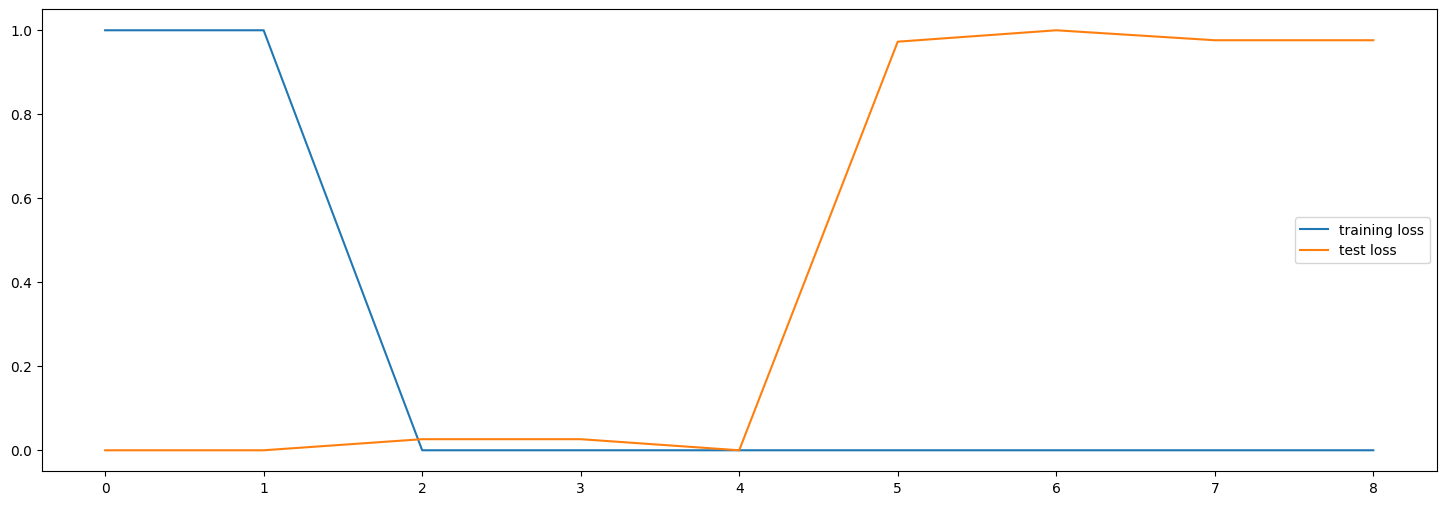

In [58]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()

Elapsed time: 0:00:00.030395
peak memory: 452.91 MiB, increment: 0.00 MiB
True HR: 49.059233449477354; Pred HR: 63.24705882352941


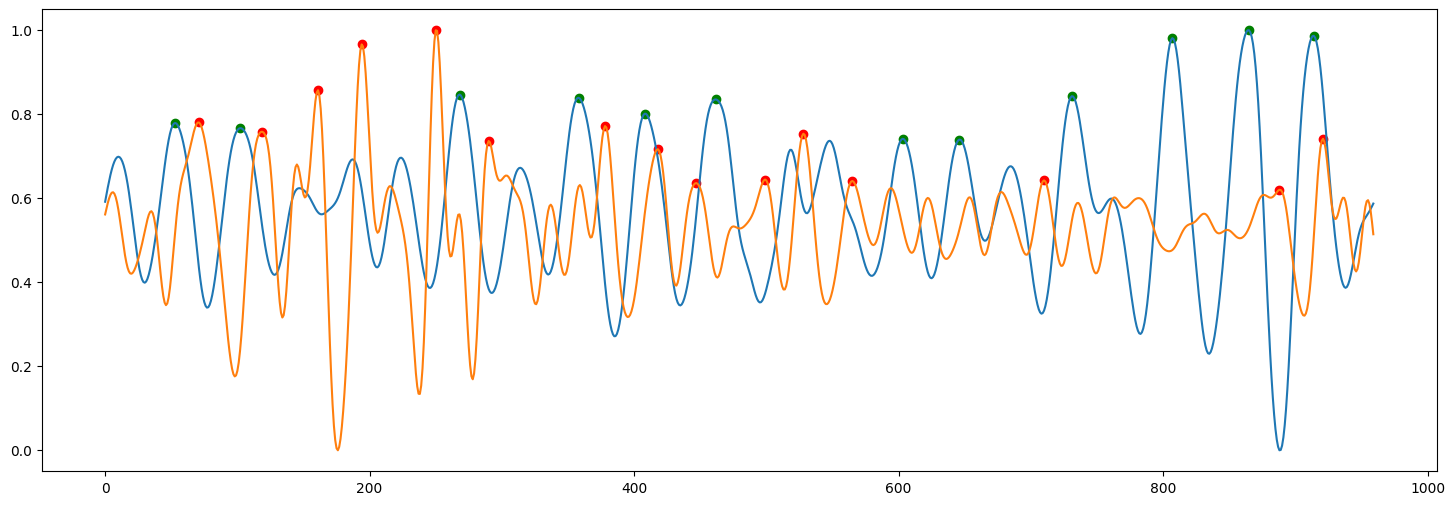

In [84]:
beg = 3000
end = beg + 960

model = mod

data = truths[2].prepare_data_for_ml(8, 12)
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = model.predict(x)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    print(f'Elapsed time: {datetime.today() - t}')
    return targ, pred

%memit targ, pred = measure_code_block()

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

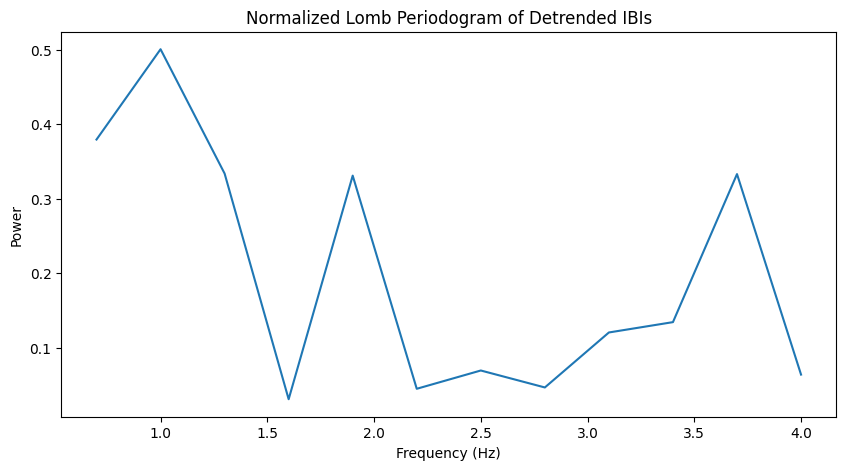

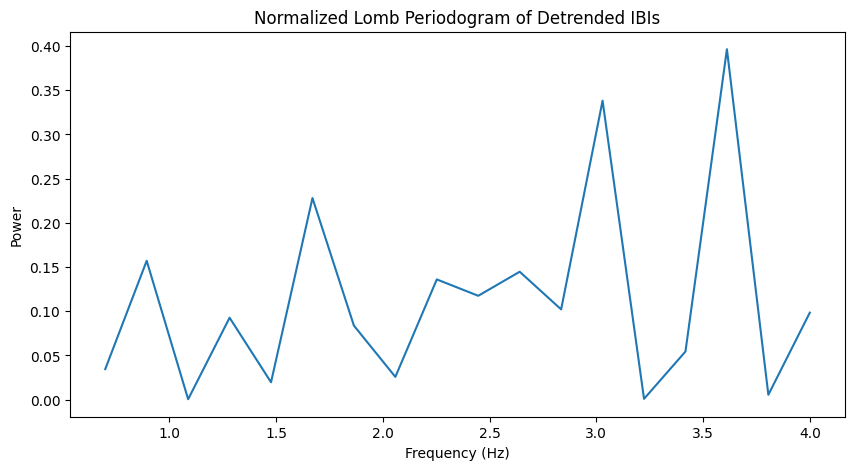

In [75]:
import scipy
def normalized_lomb_periodogram(time, ibis, frequency_range):
    """
    Calculate the normalized Lomb periodogram of detrended IBIs.

    Args:
    time (numpy array): The time values of the IBIs
    ibis (numpy array): The detrended IBIs
    frequency_range (tuple): A tuple with the minimum and maximum frequencies to consider (min_freq, max_freq)

    Returns:
    (numpy array, numpy array): The frequencies and corresponding Lomb periodogram values
    """

    # Calculate the Lomb periodogram
    angular_frequencies = np.linspace(frequency_range[0] * 2 * np.pi, frequency_range[1] * 2 * np.pi, len(time))
    periodogram = scipy.signal.lombscargle(time, ibis, angular_frequencies, normalize=True)

    # Convert angular frequencies to regular frequencies
    frequencies = angular_frequencies / (2 * np.pi)

    return frequencies, periodogram

def plot_normalized_lomb_periodogram(time, ibis, frequency_range):
    # Calculate the Lomb periodogram using the normalized_lomb_periodogram function
    frequencies, periodogram = normalized_lomb_periodogram(time, ibis, frequency_range)

    # Create a plot using matplotlib
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, periodogram)

    # Label the axes and add a title
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Normalized Lomb Periodogram of Detrended IBIs")

    # Display the plot
    plt.show()


true_time = np.cumsum(true_ibis)
pred_time = np.cumsum(pred_ibis)

plot_normalized_lomb_periodogram(true_time, true_ibis, (0.7, 4.0))
plot_normalized_lomb_periodogram(pred_time, pred_ibis, (0.7, 4.0))



In [79]:
import numpy as np

def pearson_correlation(x, y):
    """
    Calculate the Pearson correlation coefficient between two 1D NumPy arrays.

    Args:
    x (numpy array): The first 1D NumPy array
    y (numpy array): The second 1D NumPy array

    Returns:
    float: The Pearson correlation coefficient
    """

    # Compute the correlation matrix using numpy.corrcoef
    corr_matrix = np.corrcoef(x, y)

    # Extract the correlation coefficient (off-diagonal element)
    correlation_coefficient = corr_matrix[0, 1]

    return correlation_coefficient

# Example usage:
# x = np.array([...])  # Your first 1D NumPy array
# y = np.array([...])  # Your second 1D NumPy array
# correlation = pearson_correlation(x, y)
print(pred.shape)
pearson_correlation(targ, pred)

(960,)


0.016594077710170105